<a href="https://colab.research.google.com/github/Rasheena-Arimbrathodi/Computer-Vision/blob/main/final_3d_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.draw import polygon_perimeter
from sklearn.metrics import confusion_matrix
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

# Load MRI data
data = loadmat('Brain.mat')
volume = data['T1']
label = data['label']
T1= data['T1']
# Choose a slice index for visualization
slice_index = volume.shape[0] // 2

# Initial contour (for example, as a circle)
s = np.linspace(0, 2*np.pi, 100)
r = 50  # Radius
x = r * np.cos(s) + volume.shape[1] // 2
y = r * np.sin(s) + volume.shape[2] // 2
initial_contour = np.array([x, y]).T

# Perform active contour segmentation
snake = active_contour(volume[slice_index], initial_contour, alpha=0.5, beta=0.05, gamma=0.005, max_num_iter=350)

# Rasterize snake coordinates onto a grid
rr, cc = polygon_perimeter(np.round(snake[:, 1]).astype(int), np.round(snake[:, 0]).astype(int), shape=volume[slice_index].shape)

# Create binary mask
binary_mask = np.zeros_like(volume[slice_index], dtype=bool)
binary_mask[rr, cc] = True

def calculate_metrics(segmented_volume, ground_truth):
    flat_segmented_volume = segmented_volume.flatten()
    flat_ground_truth = ground_truth.flatten()

    # Confusion matrix
    cm = confusion_matrix(flat_ground_truth, flat_segmented_volume)

    # Calculate TP, TN, FP, FN
    if cm.size == 1:  # If confusion matrix is scalar (only one class present)
        tn, fp, fn, tp = 0, 0, 0, cm.item()
    elif cm.shape == (2, 2):  # If confusion matrix has expected shape
        tn, fp, fn, tp = np.ravel(cm)
    else:  # If confusion matrix has unexpected shape
        tn, fp, fn, tp = 0, 0, 0, 0

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)if (tp + fn+fp+tn) != 0 else 0


    # Dice coefficient
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0

    return specificity, sensitivity, accuracy, dice

# Calculate metrics for each slice and aggregate for micro-averaging
specificity_sum = 0
sensitivity_sum = 0
accuracy_sum = 0
dice_sum = 0
num_slices = 10

for i in range(num_slices):
    # Perform segmentation for each slice (you need to implement this part)
    # Here, we're assuming that the segmentation is already performed and you have the binary mask for each slice
    binary_mask = np.zeros_like(volume[i], dtype=bool)
    # Rest of the segmentation code goes here

    # Calculate metrics for the current slice
    specificity, sensitivity, accuracy, dice = calculate_metrics(binary_mask, label[i])

    # Aggregate metrics
    specificity_sum += specificity
    sensitivity_sum += sensitivity
    accuracy_sum += accuracy
    dice_sum += dice

# Calculate micro-averaged metrics
micro_specificity = specificity_sum / num_slices
micro_sensitivity = sensitivity_sum / num_slices
micro_accuracy = accuracy_sum / num_slices
micro_dice = dice_sum / num_slices
# Calculate PSNR, SSIM, and MSE between the segmented volume and ground truth
psnr = peak_signal_noise_ratio(binary_mask.astype(float), label[slice_index].astype(float))
ssim = structural_similarity(binary_mask.astype(float), label[slice_index].astype(float))
mse = mean_squared_error(binary_mask.astype(float), label[slice_index].astype(float))

print("PSNR:", psnr)
print("SSIM:", ssim)
print("MSE:", mse)
print("Micro-Averaged Specificity:", micro_specificity)
print("Micro-Averaged Sensitivity (Recall):", micro_sensitivity)
print("Micro-Averaged Accuracy:", micro_accuracy)
print("Micro-Averaged Dice Coefficient:", micro_dice)


PSNR: -10.449892911160706
SSIM: 0.02462268836052577
MSE: 11.09147465437788
Micro-Averaged Specificity: 0.3
Micro-Averaged Sensitivity (Recall): 0.7
Micro-Averaged Accuracy: 0.994331797235023
Micro-Averaged Dice Coefficient: 0.7


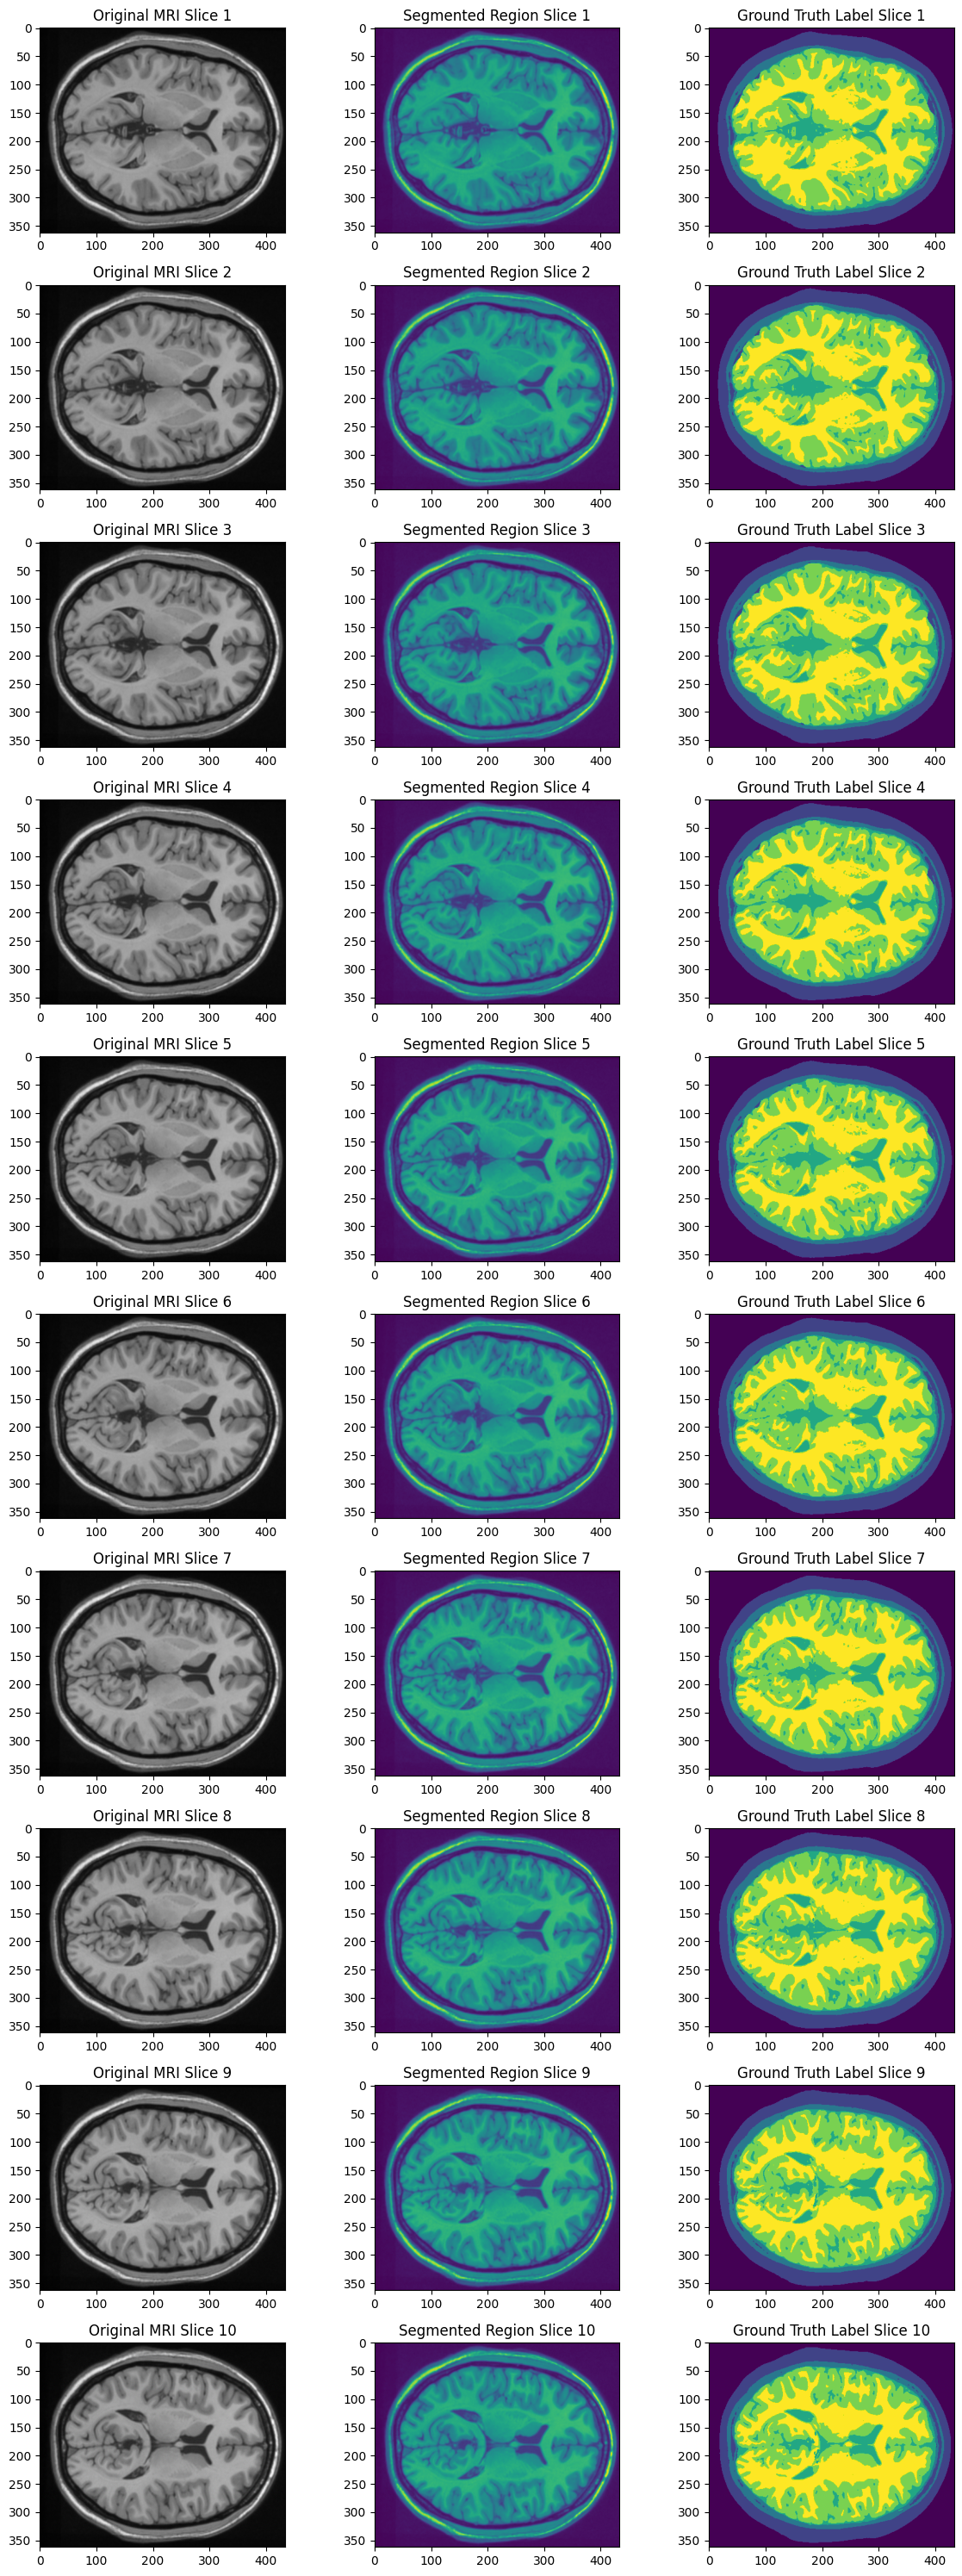

In [ ]:
# Visualize segmentation results for all slices without splitting into strips
num_slices = T1.shape[2]
fig, axs = plt.subplots(num_slices, 3, figsize=(12, 3*num_slices))
for i in range(num_slices):
    axs[i, 0].imshow(T1[:,:,i], cmap='gray')
    axs[i, 0].set_title(f"Original MRI Slice {i+1}")

    axs[i, 1].imshow(volume[:,:,i], cmap='viridis')
    axs[i, 1].set_title(f"Segmented Region Slice {i+1}")

    axs[i, 2].imshow(label[:,:,i], cmap='viridis')
    axs[i, 2].set_title(f"Ground Truth Label Slice {i+1}")

plt.tight_layout()
plt.show()
